In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA

In [2]:
# Load data
customers = pd.read_csv('/content/Customers.csv')
transactions = pd.read_csv('/content/Transactions.csv')

In [3]:
# Display first few rows of each dataset
print("Customers Data:")
print(customers.head())

print("\nTransactions Data:")
print(transactions.head())

Customers Data:
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15

Transactions Data:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  


In [5]:
# Merge datasets on CustomerID
data = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID': 'count'
}).reset_index()
data

,CustomerID,TotalValue,TransactionID
0,C0001,3354.52,5
1,C0002,1862.74,4
2,C0003,2725.38,4
3,C0004,5354.88,8
4,C0005,2034.24,3
...,...,...,...
194,C0196,4982.88,4
195,C0197,1928.65,3
196,C0198,931.83,2
197,C0199,1979.28,4


In [6]:
# Rename columns
data.rename(columns={'TotalValue': 'TotalSpent', 'TransactionID': 'PurchaseFreq'}, inplace=True)
data

,CustomerID,TotalSpent,PurchaseFreq
0,C0001,3354.52,5
1,C0002,1862.74,4
2,C0003,2725.38,4
3,C0004,5354.88,8
4,C0005,2034.24,3
...,...,...,...
194,C0196,4982.88,4
195,C0197,1928.65,3
196,C0198,931.83,2
197,C0199,1979.28,4


In [8]:
# Merge with customer data
final_df = pd.merge(customers, data, on='CustomerID', how='inner')
final_df

,CustomerID,CustomerName,Region,SignupDate,TotalSpent,PurchaseFreq
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,5
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,4
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,4
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,8
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,3
...,...,...,...,...,...,...
194,C0196,Laura Watts,Europe,2022-06-07,4982.88,4
195,C0197,Christina Harvey,Europe,2023-03-21,1928.65,3
196,C0198,Rebecca Ray,Europe,2022-02-27,931.83,2
197,C0199,Andrea Jenkins,Europe,2022-12-03,1979.28,4


In [9]:
# Select relevant numerical features
features = final_df[['TotalSpent', 'PurchaseFreq']]
features

,TotalSpent,PurchaseFreq
0,3354.52,5
1,1862.74,4
2,2725.38,4
3,5354.88,8
4,2034.24,3
...,...,...
194,4982.88,4
195,1928.65,3
196,931.83,2
197,1979.28,4


In [10]:
# Normalize data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_features

array([[-0.06170143, -0.01145819],
       [-0.87774353, -0.46749414],
       [-0.40585722, -0.46749414],
       [ 1.03254704,  1.35664965],
       [-0.78392861, -0.92353008],
       [ 0.41587942, -0.46749414],
       [-0.48548229, -0.92353008],
       [ 0.43997044,  2.26872154],
       [-1.40630171, -0.92353008],
       [-0.9571662 , -0.46749414],
       [ 0.14369581, -0.01145819],
       [ 0.96492372,  0.9006137 ],
       [ 1.38575064,  0.9006137 ],
       [-1.72239508, -1.83560198],
       [-1.26353893, -1.37956603],
       [ 0.22269727, -0.01145819],
       [ 0.70375173,  1.35664965],
       [ 0.71908486, -0.01145819],
       [-0.70101045,  0.44457776],
       [-1.39212827, -1.83560198],
       [ 1.0681256 ,  1.35664965],
       [ 0.64973294,  0.44457776],
       [ 0.92520418,  0.44457776],
       [ 0.08736309,  0.9006137 ],
       [-1.02704328, -0.46749414],
       [ 0.04471149, -0.46749414],
       [-0.49471609, -0.46749414],
       [ 1.83377022,  1.35664965],
       [-0.9197934 ,

In [11]:
# Determine optimal clusters using Elbow Method
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

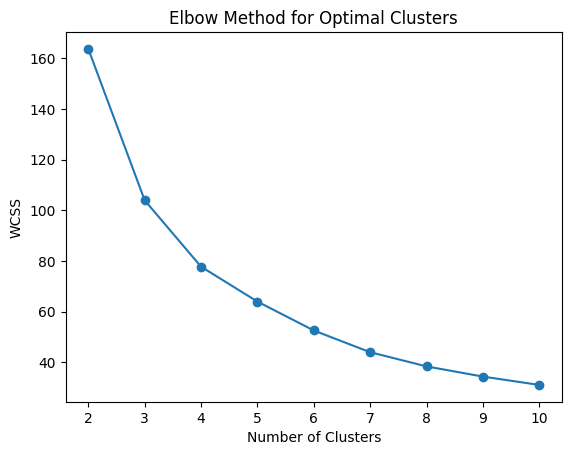

In [12]:
# Plot Elbow Method
plt.plot(range(2, 11), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

In [13]:
# Choose optimal clusters (based on elbow point)
optimal_clusters = 3

In [14]:
# Apply K-Means
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
final_df['Cluster'] = kmeans.fit_predict(scaled_features)

In [15]:
# Evaluate clustering
db_index = davies_bouldin_score(scaled_features, final_df['Cluster'])
sil_score = silhouette_score(scaled_features, final_df['Cluster'])

print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Silhouette Score: {sil_score:.4f}")

Davies-Bouldin Index: 0.7662
Silhouette Score: 0.4235


In [16]:
# PCA for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
final_df['PCA1'] = pca_features[:, 0]
final_df['PCA2'] = pca_features[:, 1]

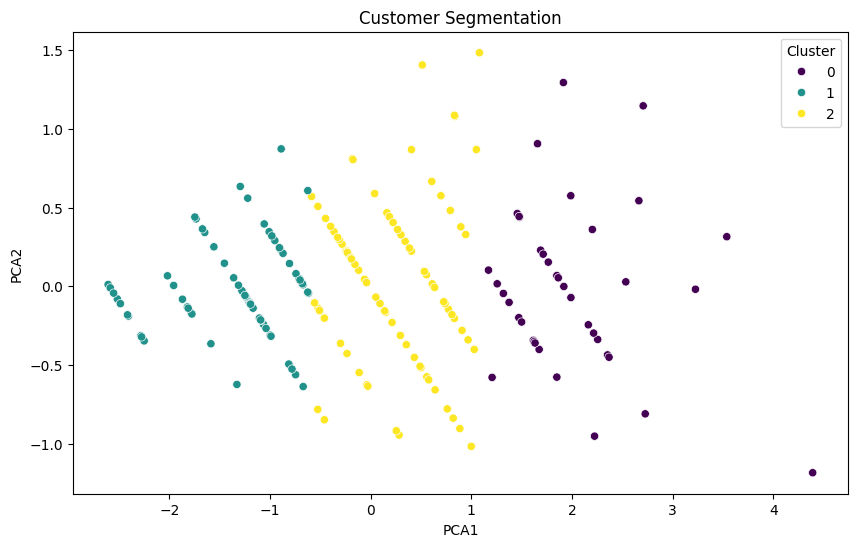

In [17]:
# Scatter plot of clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=final_df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis')
plt.title('Customer Segmentation')
plt.show()